In this branch I will:

    1. create 3 different vanilla networks and train them on the MNITS dataset
    2. create adversarial examples on one network and check their effectiveness on the other networks
    3. create vanila network with compressed sensing inputs and check its immunity to the adversarial examples 


based on the article:
https://medium.com/@ml.at.berkeley/tricking-neural-networks-create-your-own-adversarial-examples-a61eb7620fd8

modifications:
    1. MNIST dataset load by keras predefined func
    2. data prep by personal fuctions
        * y_test is categorical vector ->argmax() added at specific places
    3. "Network"class is directly in the code
    4. modification for Py3 enviroment:
        * zip() -> list(zip())
        * xrange -> range
        

    

Initializtion 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle 
#import network.mnist_loader as mnist_loader [ND-] 
import matplotlib.pyplot as plt
import random
import math
from scipy.linalg import hadamard

 #[ND+]
#from sklearn.model_selection import train_test_split
#from tensorflow.python import keras
import keras
#from tensorflow.python.keras.models import Sequential
#from tensorflow.python.keras.layers import Dense

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.



Using TensorFlow backend.


/kaggle/input/pretrained-net/trained_network.pkl
/kaggle/input/19-04-models-augmented/augmented_model3.pickle
/kaggle/input/19-04-models-augmented/augmented_model2.pickle
/kaggle/input/19-04-models-augmented/model2.pickle
/kaggle/input/19-04-models-augmented/augmented_model1.pickle
/kaggle/input/19-04-models-augmented/model3.pickle
/kaggle/input/19-04-models-augmented/model1.pickle
/kaggle/input/network/network.py


adding the "network" class from 	https://medium.com/@ml.at.berkeley/tricking-neural-networks-create-your-own-adversarial-examples-a61eb7620fd8
![image.png]

In [2]:
class Network(object):

    def __init__(self, sizes):
        """The list ``sizes`` contains the number of neurons in the
        respective layers of the network.  For example, if the list
        was [2, 3, 1] then it would be a three-layer network, with the
        first layer containing 2 neurons, the second layer 3 neurons,
        and the third layer 1 neuron.  The biases and weights for the
        network are initialized randomly, using a Gaussian
        distribution with mean 0, and variance 1.  Note that the first
        layer is assumed to be an input layer, and by convention we
        won't set any biases for those neurons, since biases are only
        ever used in computing the outputs from later layers."""
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in list(zip(sizes[:-1], sizes[1:]))]

    def adversarial(self, n):
        goal = np.zeros((10, 1))
        goal[n] = 1

        x = np.random.normal(.5, .3, (784, 1))
        orig = np.copy(x)

        for i in range(10000):
            d = self.input_derivative(x,goal)
            x -= .01 * d

        return x

    def feedforward(self, a):
        """Return the output of the network if ``a`` is input."""
        for b, w in list(zip(self.biases, self.weights)):
            a = sigmoid(np.dot(w, a)+b)
        return a

    def SGD(self, training_data, epochs, mini_batch_size, eta,
            test_data=None):
        """Train the neural network using mini-batch stochastic
        gradient descent.  The ``training_data`` is a list of tuples
        ``(x, y)`` representing the training inputs and the desired
        outputs.  The other non-optional parameters are
        self-explanatory.  If ``test_data`` is provided then the
        network will be evaluated against the test data after each
        epoch, and partial progress printed out.  This is useful for
        tracking progress, but slows things down substantially."""
        if test_data: n_test = len(test_data)
        n = len(training_data)
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta)
            if test_data:
                print("Epoch {0}: {1} / {2}".format(
                    j, self.evaluate(test_data), n_test))
            else:
                print("Epoch {0} complete".format(j))

    def update_mini_batch(self, mini_batch, eta):
        """Update the network's weights and biases by applying
        gradient descent using backpropagation to a single mini batch.
        The ``mini_batch`` is a list of tuples ``(x, y)``, and ``eta``
        is the learning rate."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in list(zip(nabla_b, delta_nabla_b))]
            nabla_w = [nw+dnw for nw, dnw in list(zip(nabla_w, delta_nabla_w))]
        self.weights = [w-(eta/len(mini_batch))*nw
                        for w, nw in list(zip(self.weights, nabla_w))]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in list(zip(self.biases, nabla_b))]

    def backprop(self, x, y):
        """Return a tuple ``(nabla_b, nabla_w)`` representing the
        gradient for the cost function C_x.  ``nabla_b`` and
        ``nabla_w`` are layer-by-layer lists of numpy arrays, similar
        to ``self.biases`` and ``self.weights``."""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in list(zip(self.biases, self.weights)): #[ND] - "list" added 
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)

    def input_derivative(self, x, y):
        """ Calculate derivatives wrt the inputs"""
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in list(zip(self.biases, self.weights)): #[ND] - "list" added
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = self.cost_derivative(activations[-1], y) * \
            sigmoid_prime(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        # Note that the variable l in the loop below is used a little
        # differently to the notation in Chapter 2 of the book.  Here,
        # l = 1 means the last layer of neurons, l = 2 is the
        # second-last layer, and so on.  It's a renumbering of the
        # scheme in the book, used here to take advantage of the fact
        # that Python can use negative indices in lists.
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return self.weights[0].T.dot(delta)

    def evaluate(self, test_data):
        """Return the number of test inputs for which the neural
        network outputs the correct result. Note that the neural
        network's output is assumed to be the index of whichever
        neuron in the final layer has the highest activation."""
        test_results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in test_data]
        return sum(int(x == np.argmax(y)) for (x, y) in test_results) #[ND] - converted y to argmax from categorical

    def cost_derivative(self, output_activations, y):
        """Return the vector of partial derivatives \partial C_x /
        \partial a for the output activations."""
        
        #[ND]-debug
        # print("output_activations shape: {0} | y shape: {1} ".format(output_activations.shape, y.shape))
        
        return (output_activations-y)

#### Miscellaneous functions
def sigmoid(z): #[ND] original sigmoid
    """The sigmoid function."""
    return 1.0/(1.0+np.exp(-z))

#def sigmoid(x): #[ND] numerical stable sigmoid
#    "Numerically stable sigmoid function."
#    if x >= 0:
#        z = np.exp(-x)
#        return 1 / (1 + z)
#    else:
        # if x is less than zero then z will be small, denom can't be
        # zero because it's 1+z.
#        z = np.exp(x)
#        return z / (1 + z)

def sigmoid_prime(z):
    """Derivative of the sigmoid function."""
    return sigmoid(z)*(1-sigmoid(z))


Loading the MNIST dataset !by keras!
use "data_prep" and create validation dataset by validation factor split


In [3]:
def data_prep(raw_x,raw_y,img_rows,img_cols, num_classes):
    num_images = raw_x.shape[0]  # get number of images
    out_x = raw_x / 255  #rescale GL to 0-1
    out_x = [np.reshape(x, (784, 1)) for x in out_x[:,:,:]]
    out_y = keras.utils.to_categorical(raw_y, num_classes)  # create y as class vector
    out_y = [np.reshape(y, (10, 1)) for y in out_y[:]]
    dataset = list(zip(out_x, out_y))
    return dataset

def MNIST_load(validation_factor):
    (X_train_raw, Y_train_raw), (X_test_raw, Y_test_raw) = keras.datasets.mnist.load_data()
    train_size = round(X_train_raw.shape[0]*validation_factor)
    train_set = data_prep(X_train_raw, Y_train_raw,img_rows=28, img_cols=28, num_classes=10)
    test_set = data_prep(X_test_raw, Y_test_raw,img_rows=28, img_cols=28, num_classes=10)
    return (train_set[0:train_size], train_set[train_size:], test_set)

(tr_set, vl_set, ts_set) = MNIST_load(validation_factor = 0.8)
    

11493376/11490434 [==============================] - 2s 0us/step


observing the train set

Classification: 0



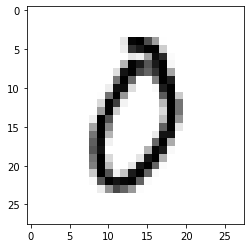

In [4]:
rand_im = tr_set[np.random.randint(1,len(tr_set))]
print('Classification: ' + str(np.argmax(rand_im[1])) + '\n')

plt.imshow(rand_im[0].reshape(28,28), cmap='Greys')



In [ ]:
struct = ([784,30,10],
          [784,20,10],
          [784,50,30,10])
          

'''
struct = ([784,30,10],
          [784,50,10],
          [784,20,10],
          [784,50,30,10],
          [784,30,20,10])
'''

for i,x in enumerate(struct,start=1):
    print('---------------------------------------------\n' +
        'model {0} | network struct is: {1}'.format(i,x))
    model = Network(x)
    model.SGD(tr_set, 10, 10, 3.0, vl_set)
    net_name = 'model'+ str(i)
    vars()[net_name] = model
    
    print("model {0} test: {1} / {2}".format(
                    i, model.evaluate(ts_set), len(ts_set)))
    
    with open(net_name + '.pickle', 'wb') as f:
        pickle.dump(model, f)
        
    
    

Checking model performance

In [ ]:
with open('model1.pickle', 'rb') as f:
    model1 = pickle.load(f)

In [ ]:
def predict(n):
    # Get the data from the test set
    x = ts_set[n][0]

    # Print the prediction of the network
    print('Network output: \n' + str(np.round(model.feedforward(x), 2)) + '\n')
    print('Network prediction: ' + str(np.argmax(model.feedforward(x))) + '\n')
    print('Actual image: ')
    
    # Draw the image
    plt.imshow(x.reshape((28,28)), cmap='Greys')

# [ND] made selection random
i = np.random.randint(1,len(ts_set)) #[ND] made random choise
predict(i)

non targeted by:
$$ C = \frac{1}{2} \|\vec y_{goal} - \hat y(\vec x)\|^2_2 $$

In [ ]:
def adversarial(net, n, steps, eta):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    """
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = model.input_derivative(x,goal)
        
        # The GD update on x
        x -= eta * d
        
    return x

# Wrapper function
def generate(n):
    """
    n : integer
        goal label (not a one hot vector)
    """
    (a) = adversarial(model, n, 1000, 1)
    x = np.round(model.feedforward(a), 2)
    
    
    print('Network Output: \n' + str(x) + '\n')
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Adversarial Example: ')
    plt.imshow(a.reshape(28,28), cmap='Greys')

In [ ]:
generate(0)

targeted by:
$$ C = \|\vec y_{goal} - y_{hat}(\vec x)\|^2_2 + \lambda \|\vec x - \vec x_{target}\|^2_2 $$

In [ ]:
def sneaky_adversarial(model, n, x_target, steps, eta, lam=.05):
    """
    net : network object
        neural network instance to use
    n : integer
        our goal label (just an int, the function transforms it into a one-hot vector)
    x_target : numpy vector
        our goal image for the adversarial example
    steps : integer
        number of steps for gradient descent
    eta : float
        step size for gradient descent
    lam : float
        lambda, our regularization parameter. Default is .05
    """
    
    # Set the goal output
    goal = np.zeros((10, 1))
    goal[n] = 1

    # Create a random image to initialize gradient descent with
    x = np.random.normal(.5, .3, (784, 1))

    # Gradient descent on the input
    for i in range(steps):
        # Calculate the derivative
        d = model.input_derivative(x,goal)
        
        # The GD update on x, with an added penalty to the cost function
        # ONLY CHANGE IS RIGHT HERE!!!
        x -= eta * (d + lam * (x - x_target))

    return x

# Wrapper function
def sneaky_generate(model, n, m):
    """
    n: int 0-9, the target number to match
    m: index of example image to use (from the test set)
    """
    
    # Find random instance of m in test set
    idx = np.random.randint(0,8000)
    while np.argmax(ts_set[idx][1]) != m:
        idx += 1
    
    # Hardcode the parameters for the wrapper function
    a = sneaky_adversarial(model, n, ts_set[idx][0], 100, 1)
    x = np.round(model.feedforward(a), 2)
    
    print('\nWhat we want our adversarial example to look like: ')
    plt.imshow(ts_set[idx][0].reshape((28,28)), cmap='Greys')
    plt.show()
    
    print('\n')
    
    print('Adversarial Example: ')
    
    plt.imshow(a.reshape(28,28), cmap='Greys')
    plt.show()
    
    print('Network Prediction: ' + str(np.argmax(x)) + '\n')
    
    print('Network Output: \n' + str(x) + '\n')
    
    return a

In [ ]:
# sneaky_generate(target label, target digit)
adv_ex = sneaky_generate(model,8, 5)

In [ ]:
def augment_data(model, n, data, steps):
    """
    n : integer
        number of adversarial examples to generate
    data : list of tuples
        data set to generate adversarial examples using
    """
    # Our augmented training set:
    augmented = []
    
    for i in range(n):
        # Progress "bar"
        if i % 500 == 0:
            print("Generated digits: " + str(i))
            
        # Randomly choose a digit that the example will look like
        rnd_actual_digit = np.random.randint(10)
        
        # Find random instance of rnd_actual_digit in the training set
        rnd_actual_idx = np.random.randint(len(data))
        while np.argmax(data[rnd_actual_idx][1]) != rnd_actual_digit:
            rnd_actual_idx = np.random.randint(len(data))
        x_target = data[rnd_actual_idx][0]
        
        # Choose value for adversarial attack
        rnd_fake_digit = np.random.randint(10)
        
        # Generate adversarial example
        x_adversarial = sneaky_adversarial(model, rnd_fake_digit, x_target, steps, 1)
        
        # Add new data
        y_actual = data[rnd_actual_idx][1]
        
        augmented.append((x_adversarial, y_actual))
        
    return augmented

generate augmented data per network and pickle it

In [ ]:
for i,x in enumerate(struct,start=1):
    
    net_name = 'model'+ str(i)
    augmented_name = 'augmented_' + net_name
    
    print('---------------create augmented --------------\n' +
        '{0} | network struct is: {1} | evaluated data is: {2}'.format(net_name,x, augmented_name))    
    #with open(net_name + '.pickle', 'rb') as f:
       #vars()['model' + str(i)] = pickle.load(f)
          
    vars()[augmented_name] = augment_data(vars()['model' + str(i)], 20000, tr_set, 100)
      
    with open(augmented_name + '.pickle', 'wb') as f:
        pickle.dump(augmented_name, f)

Load networks and Augmented datasets

In [ ]:
struct = ([784,30,10],
          [784,20,10],
          [784,50,30,10])

for i,y in enumerate(struct,start=1):
    
    print('-------------------------------------\n')
    augmented_name = 'augmented_model' + str(i) 
    with open('/kaggle/input/19-04-models-augmented/' + augmented_name + '.pickle', 'rb') as f:
        vars()[augmented_name] = pickle.load(f)
        
    net_name = 'model'+ str(i)
    with open('/kaggle/input/19-04-models-augmented/' + net_name + '.pickle', 'rb') as f:
        vars()[net_name] = pickle.load(f)
        
    print('{0} loaded successfully | {1} loaded successfully '.format(net_name, augmented_name))

In [ ]:
for i,y in enumerate(struct,start=1):
    
    augmented_name = 'augmented_model' + str(i)
    augmented = vars()[augmented_name]
    
    print('---------------evaluate {0} --------------'.format(augmented_name))
       
    
    for j,x in enumerate(struct,start=1):
        net_name = 'model'+ str(j)
        model = vars()[net_name]
      
        print("{0} | network struct is: {1} | test: {2} / {3}".format(
                    net_name, x, model.evaluate(augmented), len(augmented)))
    print('\n')
    

reviewing the new dataset

In [ ]:
rand_im = augmented[np.random.randint(1,len(augmented))]
print('Classification: ' + str(np.argmax(rand_im[1])) + '\n')

plt.imshow(rand_im[0].reshape(28,28), cmap='Greys')

In [ ]:
#def compressive_sample(im, compr_ratio, scrambl_arr, H):
    '''
    simulate single pxl camera sampling by Hadamard mat
    '''
    
    # the MNIST image is 28 by 28, so first we pad the image by zeros
    n = len(H)
        
    im_pad = np.zeros([n,n])
    im_pad[2:30,2:30] = im #[ND] convert to python indx
    
    N = im_pad.size #[ND] full padded image
    
    M = int(np.ceil(compr_ratio * N)) 
   

        
    
    
    #simulate scrambled hadamard sampling:
    im_scrambl = im_pad    
    im_scrambl = np.take(im_pad,[scrambl_arr]).reshape(32,32)

    
    samp_mat = H.dot(im_scrambl).dot(H)

    compressive_array = np.take(samp_mat,list(range(M)))
    
    return compressive_array

In [ ]:
def decompress(compr_vec, scrambl_arr, H):
    n = len(H)
        
    im_pad = np.zeros([n,n])
    np.put(im_pad,list(range(len(compr_vec))),compr_vec)
    
    decomp_mat = H.dot(im_pad).dot(H)
    
    unscrambled_im = np.zeros([n,n])
    np.put(unscrambled_im, scrambl_arr, decomp_mat)
    
    return unscrambled_im
    #return unscrambled_im

In [ ]:
# choose M random numbers out of 1 to N (no repetitions)
# this will be the key
scrambl_arr = np.array([1,605,16,880,199,488,579,24,478,948,470,1022,309,5,295,608,831,13,26,132,716,743,977,517,231,544,212,180,73,894,590,893,816,346,243,970,31,639,45,296,312,911,423,122,42,44,200,869,844,197,887,40,522,693,591,702,361,845,527,654,498,422,803,641,651,602,598,523,137,511,348,54,366,267,487,363,1013,486,761,240,698,55,968,753,239,279,964,48,373,15,429,1005,326,989,857,745,739,253,79,304,10,785,872,161,901,219,865,419,307,116,188,723,707,168,362,835,735,573,934,813,928,978,710,584,909,746,514,915,1006,537,169,107,316,820,60,578,46,726,124,917,150,479,201,592,828,601,396,374,534,449,667,359,700,780,533,502,760,186,564,425,773,142,613,771,764,955,530,342,29,518,1009,154,990,841,576,247,611,492,703,658,896,65,810,317,7,661,626,678,689,49,454,85,67,323,504,457,327,236,411,173,395,848,749,866,261,360,732,790,78,165,409,926,770,59,672,903,351,276,410,875,1015,290,83,499,416,114,836,298,559,811,182,144,682,808,272,433,469,615,94,1001,560,908,906,340,325,980,851,56,1000,347,381,461,444,174,950,846,966,907,556,273,237,476,884,23,634,690,210,11,490,575,650,673,466,345,563,57,284,796,642,715,443,227,17,829,248,607,39,916,264,819,983,313,681,562,1020,627,889,402,725,720,713,18,849,350,226,215,32,412,957,365,680,528,430,204,566,496,255,825,838,897,994,648,910,833,687,777,549,268,1014,548,789,508,271,367,609,275,483,450,954,364,582,105,798,451,618,164,389,1023,468,669,752,115,191,246,1017,721,781,475,320,628,254,923,62,991,814,249,100,558,976,864,216,676,774,604,863,905,666,679,482,924,1008,308,459,633,390,119,232,319,369,684,988,940,712,25,516,491,12,765,506,620,357,1021,624,569,462,699,103,96,349,352,385,898,280,160,401,949,143,668,438,190,979,84,596,547,589,755,375,112,77,973,27,740,47,300,208,489,951,252,370,314,692,383,733,440,588,74,554,331,446,140,617,465,837,1002,195,852,747,614,921,756,282,677,424,19,184,795,136,512,766,919,935,408,714,939,384,99,1004,8,53,775,98,130,245,286,126,353,177,603,452,139,157,386,797,238,638,336,3,881,251,95,158,455,344,521,655,269,2,495,737,397,400,960,30,69,225,899,175,163,565,688,355,930,871,427,185,536,532,442,250,987,629,285,696,754,568,407,117,697,256,984,162,738,447,944,176,171,262,925,758,741,904,519,206,972,593,1007,394,817,997,767,722,762,938,90,1012,711,616,148,299,612,21,931,445,727,729,507,858,933,220,806,274,552,574,172,387,840,631,818,97,128,515,72,670,377,58,404,832,102,958,93,675,902,343,996,649,464,270,947,209,861,783,709,260,436,33,391,179,524,221,471,89,546,167,354,413,975,652,784,500,104,623,152,155,414,310,599,969,830,826,557,885,127,637,417,322,43,420,257,942,135,258,52,827,194,526,748,570,441,791,224,241,539,1010,914,432,812,644,1018,398,801,659,91,234,995,824,458,663,913,945,862,339,856,927,772,9,337,646,800,982,335,118,671,674,81,503,900,718,87,41,594,34,61,214,892,259,854,473,794,358,974,181,266,708,736,998,382,657,664,805,683,842,303,701,277,936,480,263,484,625,542,635,986,131,632,108,971,283,529,448,561,306,321,228,538,929,867,324,38,133,937,406,531,51,20,138,804,178,932,730,742,961,330,82,653,550,577,763,205,728,717,757,493,1003,802,485,456,211,14,129,1024,787,431,86,203,481,860,540,610,595,1011,294,793,121,125,520,993,235,788,704,769,418,647,744,815,870,686,734,439,943,106,202,847,967,146,799,147,460,217,71,606,111,912,334,329,510,151,586,230,318,640,645,305,952,882,428,287,159,37,393,525,572,64,376,694,434,193,656,371,1016,600,873,992,110,895,63,368,571,660,541,315,301,378,379,198,886,877,332,850,192,145,705,218,665,399,918,472,587,50,750,356,494,695,405,196,229,622,859,792,403,807,291,853,874,222,153,4,244,1019,776,149,543,963,302,113,388,338,545,883,36,981,242,691,786,751,474,66,959,80,435,553,288,76,170,189,965,453,759,555,109,879,68,292,535,437,956,567,619,920,855,581,233,724,551,778,731,685,868,265,426,843,183,580,878,223,509,281,636,213,891,123,477,35,92,88,341,380,782,505,706,372,513,22,822,501,297,985,207,333,779,630,463,289,467,75,821,311,70,156,809,643,888,141,953,941,834,6,187,962,415,839,101,28,823,293,120,328,134,999,662,392,278,597,166,421,497,583,621,922,946,876,585,768,890,719]
                          ,dtype=int) 

scrambl_arr = np.subtract(scrambl_arr, 1) #[ND] convert to python indx

# sampling matrix:
H = hadamard(32)/math.sqrt(32)

compressed_im = compressive_sample(rand_im[0].reshape(28,28), 0.8, scrambl_arr, H)

decomp_im = decompress(compressed_im, scrambl_arr, H)


plt.figure(0)
plt.title('original image is:')
plt.imshow(rand_im[0].reshape(28,28))

'''
plt.figure(1)
plt.title('compressed image is:')
plt.imshow(compressed_im.reshape(32,32))
'''


plt.figure(2)
plt.title('decompressed image is:')
plt.imshow(decomp_im)


In [53]:
class cs_dataset(object):
    
    def __init__(self, scramble_key, compression_ratio, H_dim):
        '''
        object for cs datasets. It include all requiered operations. hold tr, ts, vl datasets and the relevant cs parameters (see in 'self')
        '''
        self.scramble_key = scramble_key
        self.compression_ratio = compression_ratio
        self.H = hadamard(H_dim)/math.sqrt(H_dim)
        #self.cs_tr_set = []
        #self.cs_vl_set = []
        #self.cs_ts_set = []
        
    def create_cs_dataset(self, dataset_input, dataset_name):
        '''
        recieve normal dataset as list of x,y and convert to cs dataset of cs_x,y
        dataset_name['tr', 'ts', 'vl']
        '''
        out_dataset = []
        for i,data in enumerate(dataset_input):         
            out_dataset.append([cs_dataset.compressive_sample(self,data[0].reshape(28,28)),  data[1]]) 
                
        if dataset_name == 'tr':
            self.cs_tr_set = out_dataset
            print('\033[1;32;40m cs_tr_set created successfuly\n')
        else:
            if dataset_name == 'vl':
                print('\033[1;32;40m cs_vl_set created successfuly\n')
                self.cs_vl_set = out_dataset
            else:
                if dataset_name == 'ts':
                    self.cs_ts_set = out_dataset
                    print('\033[1;32;40m cs_ts_set created successfuly\n')
                else:
                    print('invalid target dataset')
                    
        
            
    def compressive_sample(self,im):
        '''
        simulate single pxl camera sampling by Hadamard mat
        '''
        # the MNIST image is 28 by 28, so first we pad the image by zeros
        n = len(self.H)
        im_pad = np.zeros([n,n])
        im_pad[2:30,2:30] = im #[ND] convert to python indx
        N = im_pad.size #[ND] full padded image
        M = int(np.ceil(self.compression_ratio * N)) 

        #simulate scrambled hadamard sampling:
        im_scrambl = im_pad    
        im_scrambl = np.take(im_pad,[self.scramble_key]).reshape(32,32)
        samp_mat = self.H.dot(im_scrambl).dot(self.H)
        compressive_array = np.take(samp_mat,list(range(M)))

        return compressive_array.reshape(len(compressive_array),1)
    
    def decompress(self, compr_vec):
        
        n = len(self.H)
        im_pad = np.zeros([n,n])
        np.put(im_pad,list(range(len(compr_vec))),compr_vec)
        decomp_mat = self.H.dot(im_pad).dot(self.H)
        unscrambled_im = np.zeros([n,n])
        np.put(unscrambled_im, self.scramble_key, decomp_mat)

        return unscrambled_im
    
    def show_restored(self, dataset_name, im_number):
        if dataset_name == 'tr':
            dataset = self.cs_tr_set
        else:
            if dataset_name == 'vl':
                dataset = self.cs_vl_set
            else:
                if dataset_name == 'ts':
                    dataset = self.cs_ts_set
                else:
                    print('invalid target dataset')
                    
        decomp_im = cs_dataset.decompress(self, dataset[im_number][0])
        plt.title('decompressed image is:')
        plt.imshow(decomp_im)

    


In [54]:
scrambl_arr = np.array([1,605,16,880,199,488,579,24,478,948,470,1022,309,5,295,608,831,13,26,132,716,743,977,517,231,544,212,180,73,894,590,893,816,346,243,970,31,639,45,296,312,911,423,122,42,44,200,869,844,197,887,40,522,693,591,702,361,845,527,654,498,422,803,641,651,602,598,523,137,511,348,54,366,267,487,363,1013,486,761,240,698,55,968,753,239,279,964,48,373,15,429,1005,326,989,857,745,739,253,79,304,10,785,872,161,901,219,865,419,307,116,188,723,707,168,362,835,735,573,934,813,928,978,710,584,909,746,514,915,1006,537,169,107,316,820,60,578,46,726,124,917,150,479,201,592,828,601,396,374,534,449,667,359,700,780,533,502,760,186,564,425,773,142,613,771,764,955,530,342,29,518,1009,154,990,841,576,247,611,492,703,658,896,65,810,317,7,661,626,678,689,49,454,85,67,323,504,457,327,236,411,173,395,848,749,866,261,360,732,790,78,165,409,926,770,59,672,903,351,276,410,875,1015,290,83,499,416,114,836,298,559,811,182,144,682,808,272,433,469,615,94,1001,560,908,906,340,325,980,851,56,1000,347,381,461,444,174,950,846,966,907,556,273,237,476,884,23,634,690,210,11,490,575,650,673,466,345,563,57,284,796,642,715,443,227,17,829,248,607,39,916,264,819,983,313,681,562,1020,627,889,402,725,720,713,18,849,350,226,215,32,412,957,365,680,528,430,204,566,496,255,825,838,897,994,648,910,833,687,777,549,268,1014,548,789,508,271,367,609,275,483,450,954,364,582,105,798,451,618,164,389,1023,468,669,752,115,191,246,1017,721,781,475,320,628,254,923,62,991,814,249,100,558,976,864,216,676,774,604,863,905,666,679,482,924,1008,308,459,633,390,119,232,319,369,684,988,940,712,25,516,491,12,765,506,620,357,1021,624,569,462,699,103,96,349,352,385,898,280,160,401,949,143,668,438,190,979,84,596,547,589,755,375,112,77,973,27,740,47,300,208,489,951,252,370,314,692,383,733,440,588,74,554,331,446,140,617,465,837,1002,195,852,747,614,921,756,282,677,424,19,184,795,136,512,766,919,935,408,714,939,384,99,1004,8,53,775,98,130,245,286,126,353,177,603,452,139,157,386,797,238,638,336,3,881,251,95,158,455,344,521,655,269,2,495,737,397,400,960,30,69,225,899,175,163,565,688,355,930,871,427,185,536,532,442,250,987,629,285,696,754,568,407,117,697,256,984,162,738,447,944,176,171,262,925,758,741,904,519,206,972,593,1007,394,817,997,767,722,762,938,90,1012,711,616,148,299,612,21,931,445,727,729,507,858,933,220,806,274,552,574,172,387,840,631,818,97,128,515,72,670,377,58,404,832,102,958,93,675,902,343,996,649,464,270,947,209,861,783,709,260,436,33,391,179,524,221,471,89,546,167,354,413,975,652,784,500,104,623,152,155,414,310,599,969,830,826,557,885,127,637,417,322,43,420,257,942,135,258,52,827,194,526,748,570,441,791,224,241,539,1010,914,432,812,644,1018,398,801,659,91,234,995,824,458,663,913,945,862,339,856,927,772,9,337,646,800,982,335,118,671,674,81,503,900,718,87,41,594,34,61,214,892,259,854,473,794,358,974,181,266,708,736,998,382,657,664,805,683,842,303,701,277,936,480,263,484,625,542,635,986,131,632,108,971,283,529,448,561,306,321,228,538,929,867,324,38,133,937,406,531,51,20,138,804,178,932,730,742,961,330,82,653,550,577,763,205,728,717,757,493,1003,802,485,456,211,14,129,1024,787,431,86,203,481,860,540,610,595,1011,294,793,121,125,520,993,235,788,704,769,418,647,744,815,870,686,734,439,943,106,202,847,967,146,799,147,460,217,71,606,111,912,334,329,510,151,586,230,318,640,645,305,952,882,428,287,159,37,393,525,572,64,376,694,434,193,656,371,1016,600,873,992,110,895,63,368,571,660,541,315,301,378,379,198,886,877,332,850,192,145,705,218,665,399,918,472,587,50,750,356,494,695,405,196,229,622,859,792,403,807,291,853,874,222,153,4,244,1019,776,149,543,963,302,113,388,338,545,883,36,981,242,691,786,751,474,66,959,80,435,553,288,76,170,189,965,453,759,555,109,879,68,292,535,437,956,567,619,920,855,581,233,724,551,778,731,685,868,265,426,843,183,580,878,223,509,281,636,213,891,123,477,35,92,88,341,380,782,505,706,372,513,22,822,501,297,985,207,333,779,630,463,289,467,75,821,311,70,156,809,643,888,141,953,941,834,6,187,962,415,839,101,28,823,293,120,328,134,999,662,392,278,597,166,421,497,583,621,922,946,876,585,768,890,719]
                          ,dtype=int) 

scrambl_arr = np.subtract(scrambl_arr, 1)

cs1 = cs_dataset(scrambl_arr, compression_ratio = 0.8, H_dim = 32 )

cs1.create_cs_dataset(tr_set,'tr')
cs1.create_cs_dataset(ts_set,'ts')
cs1.create_cs_dataset(vl_set,'vl')


 cs_tr_set created successfuly

 cs_ts_set created successfuly

 cs_vl_set created successfuly



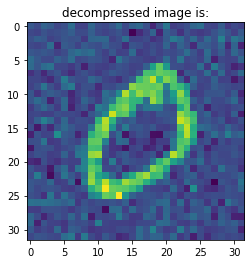

In [37]:
cs1.show_restored('tr',1)

In [59]:
cs_model = Network([len(cs1.cs_tr_set[0][0]),30,10])
cs_model.SGD(cs1.cs_tr_set, 10, 10, 3.0, cs1.cs_vl_set)

Epoch 0: 10905 / 12000
Epoch 1: 11089 / 12000
Epoch 2: 11070 / 12000
Epoch 3: 11236 / 12000
Epoch 4: 11282 / 12000
Epoch 5: 11309 / 12000
Epoch 6: 11318 / 12000
Epoch 7: 11289 / 12000
Epoch 8: 11334 / 12000
Epoch 9: 11366 / 12000


In [55]:
len(cs1.cs_tr_set[0][0])

820